In [128]:
#Dependencies
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import datetime
import holidays
from prophet import Prophet

from pathlib import Path




In [129]:
#import data
coffee_data = Path('Resources/coffee-shop-sales-revenue.csv')

print(coffee_data)

Resources\coffee-shop-sales-revenue.csv


In [130]:
#Read in the data
coffee_df = pd.read_csv(coffee_data, sep='|')

#Print out the first and last two rows
display(coffee_df.head(2))
display(coffee_df.tail(2))

,transaction_id,transaction_date,transaction_time,transaction_qty,store_id,store_location,product_id,unit_price,product_category,product_type,product_detail
0,1,2023-01-01,07:06:11,2,5,Lower Manhattan,32,3.0,Coffee,Gourmet brewed coffee,Ethiopia Rg
1,2,2023-01-01,07:08:56,2,5,Lower Manhattan,57,3.1,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg


,transaction_id,transaction_date,transaction_time,transaction_qty,store_id,store_location,product_id,unit_price,product_category,product_type,product_detail
149114,149455,2023-06-30,20:57:19,1,8,Hell's Kitchen,40,3.75,Coffee,Barista Espresso,Cappuccino
149115,149456,2023-06-30,20:57:19,2,8,Hell's Kitchen,64,0.80,Flavours,Regular syrup,Hazelnut syrup


In [131]:
#Clean the data

#Check for nulls
display(coffee_df.isnull().mean() * 100)

#remove nulls
coffee_df = coffee_df.dropna()

#Check for duplicates
display(coffee_df.duplicated().sum())

#Remove duplicates
coffee_df = coffee_df.drop_duplicates()

#Combine date and time columns into new column
coffee_df['salesdatetime'] = coffee_df['transaction_date'].astype(str) + ' ' + coffee_df['transaction_time'].astype(str)

#Convert new column to datetime
coffee_df['salesdatetime'] = pd.to_datetime(coffee_df['salesdatetime'])

#Check data types
display(coffee_df.dtypes)

#Print out the first and last two rows
display(coffee_df.head(2))
display(coffee_df.tail(2))


transaction_id      0.0
transaction_date    0.0
transaction_time    0.0
transaction_qty     0.0
store_id            0.0
store_location      0.0
product_id          0.0
unit_price          0.0
product_category    0.0
product_type        0.0
product_detail      0.0
dtype: float64

0

transaction_id               int64
transaction_date            object
transaction_time            object
transaction_qty              int64
store_id                     int64
store_location              object
product_id                   int64
unit_price                 float64
product_category            object
product_type                object
product_detail              object
salesdatetime       datetime64[ns]
dtype: object

,transaction_id,transaction_date,transaction_time,transaction_qty,store_id,store_location,product_id,unit_price,product_category,product_type,product_detail,salesdatetime
0,1,2023-01-01,07:06:11,2,5,Lower Manhattan,32,3.0,Coffee,Gourmet brewed coffee,Ethiopia Rg,2023-01-01 07:06:11
1,2,2023-01-01,07:08:56,2,5,Lower Manhattan,57,3.1,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg,2023-01-01 07:08:56


,transaction_id,transaction_date,transaction_time,transaction_qty,store_id,store_location,product_id,unit_price,product_category,product_type,product_detail,salesdatetime
149114,149455,2023-06-30,20:57:19,1,8,Hell's Kitchen,40,3.75,Coffee,Barista Espresso,Cappuccino,2023-06-30 20:57:19
149115,149456,2023-06-30,20:57:19,2,8,Hell's Kitchen,64,0.80,Flavours,Regular syrup,Hazelnut syrup,2023-06-30 20:57:19


In [132]:
#Create a new column for total sales
coffee_df['totalsales'] = coffee_df['transaction_qty'] * coffee_df['unit_price']

#Create a new column for month
coffee_df['month'] = coffee_df['salesdatetime'].dt.month

#print(coffee_df['month'])
#print(coffee_df['salesdatetime'].dt.year)
#print(coffee_df['salesdatetime'].dt.day)
#Create a new column for the week of the year
coffee_df['weekofyear'] = pd.to_datetime(coffee_df['salesdatetime']).dt.strftime('%U')

#Create a new column for day of week
coffee_df['dayofweek'] = coffee_df['salesdatetime'].dt.dayofweek

#Create a new column for hour
coffee_df['hour'] = coffee_df['salesdatetime'].dt.hour

#Print out the first and last 2 rows
display(coffee_df.head(2))
display(coffee_df.tail(2))



,transaction_id,transaction_date,transaction_time,transaction_qty,store_id,store_location,product_id,unit_price,product_category,product_type,product_detail,salesdatetime,totalsales,month,weekofyear,dayofweek,hour
0,1,2023-01-01,07:06:11,2,5,Lower Manhattan,32,3.0,Coffee,Gourmet brewed coffee,Ethiopia Rg,2023-01-01 07:06:11,6.0,1,01,6,7
1,2,2023-01-01,07:08:56,2,5,Lower Manhattan,57,3.1,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg,2023-01-01 07:08:56,6.2,1,01,6,7


,transaction_id,transaction_date,transaction_time,transaction_qty,store_id,store_location,product_id,unit_price,product_category,product_type,product_detail,salesdatetime,totalsales,month,weekofyear,dayofweek,hour
149114,149455,2023-06-30,20:57:19,1,8,Hell's Kitchen,40,3.75,Coffee,Barista Espresso,Cappuccino,2023-06-30 20:57:19,3.75,6,26,4,20
149115,149456,2023-06-30,20:57:19,2,8,Hell's Kitchen,64,0.80,Flavours,Regular syrup,Hazelnut syrup,2023-06-30 20:57:19,1.60,6,26,4,20


In [133]:
#Create a dataframe for each store
store1_df = coffee_df.loc[coffee_df['store_id'] == 3]
store2_df = coffee_df.loc[coffee_df['store_id'] == 5]
store3_df = coffee_df.loc[coffee_df['store_id'] == 8]

#Reset the index for each store to sale datetime
store1_df = store1_df.set_index('salesdatetime')
store2_df = store2_df.set_index('salesdatetime')
store3_df = store3_df.set_index('salesdatetime')


#Print out the first and last 2 rows of each store
display(store1_df.head(2))
display(store1_df.tail(2))

display(store2_df.head(2))
display(store2_df.tail(2))

display(store3_df.head(2))
display(store3_df.tail(2))



,transaction_id,transaction_date,transaction_time,transaction_qty,store_id,store_location,product_id,unit_price,product_category,product_type,product_detail,totalsales,month,weekofyear,dayofweek,hour
salesdatetime,,,,,,,,,,,,,,,,
2023-01-01 11:01:48,106,2023-01-01,11:01:48,1,3,Astoria,22,2.00,Coffee,Drip coffee,Our Old Time Diner Blend Sm,2.00,1,01,6,11
2023-01-01 11:01:58,107,2023-01-01,11:01:58,1,3,Astoria,38,3.75,Coffee,Barista Espresso,Latte,3.75,1,01,6,11


,transaction_id,transaction_date,transaction_time,transaction_qty,store_id,store_location,product_id,unit_price,product_category,product_type,product_detail,totalsales,month,weekofyear,dayofweek,hour
salesdatetime,,,,,,,,,,,,,,,,
2023-06-30 19:57:49,149448,2023-06-30,19:57:49,2,3,Astoria,54,2.50,Tea,Brewed Chai tea,Morning Sunrise Chai Rg,5.00,6,26,4,19
2023-06-30 19:57:49,149449,2023-06-30,19:57:49,1,3,Astoria,70,3.25,Bakery,Scone,Cranberry Scone,3.25,6,26,4,19


,transaction_id,transaction_date,transaction_time,transaction_qty,store_id,store_location,product_id,unit_price,product_category,product_type,product_detail,totalsales,month,weekofyear,dayofweek,hour
salesdatetime,,,,,,,,,,,,,,,,
2023-01-01 07:06:11,1,2023-01-01,07:06:11,2,5,Lower Manhattan,32,3.0,Coffee,Gourmet brewed coffee,Ethiopia Rg,6.0,1,01,6,7
2023-01-01 07:08:56,2,2023-01-01,07:08:56,2,5,Lower Manhattan,57,3.1,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg,6.2,1,01,6,7


,transaction_id,transaction_date,transaction_time,transaction_qty,store_id,store_location,product_id,unit_price,product_category,product_type,product_detail,totalsales,month,weekofyear,dayofweek,hour
salesdatetime,,,,,,,,,,,,,,,,
2023-06-30 19:40:09,149435,2023-06-30,19:40:09,2,5,Lower Manhattan,58,3.5,Drinking Chocolate,Hot chocolate,Dark chocolate Rg,7.0,6,26,4,19
2023-06-30 20:16:31,149451,2023-06-30,20:16:31,2,5,Lower Manhattan,42,2.5,Tea,Brewed herbal tea,Lemon Grass Rg,5.0,6,26,4,20


,transaction_id,transaction_date,transaction_time,transaction_qty,store_id,store_location,product_id,unit_price,product_category,product_type,product_detail,totalsales,month,weekofyear,dayofweek,hour
salesdatetime,,,,,,,,,,,,,,,,
2023-01-01 08:00:18,18,2023-01-01,08:00:18,1,8,Hell's Kitchen,42,2.5,Tea,Brewed herbal tea,Lemon Grass Rg,2.5,1,01,6,8
2023-01-01 08:00:39,19,2023-01-01,08:00:39,2,8,Hell's Kitchen,59,4.5,Drinking Chocolate,Hot chocolate,Dark chocolate Lg,9.0,1,01,6,8


,transaction_id,transaction_date,transaction_time,transaction_qty,store_id,store_location,product_id,unit_price,product_category,product_type,product_detail,totalsales,month,weekofyear,dayofweek,hour
salesdatetime,,,,,,,,,,,,,,,,
2023-06-30 20:57:19,149455,2023-06-30,20:57:19,1,8,Hell's Kitchen,40,3.75,Coffee,Barista Espresso,Cappuccino,3.75,6,26,4,20
2023-06-30 20:57:19,149456,2023-06-30,20:57:19,2,8,Hell's Kitchen,64,0.80,Flavours,Regular syrup,Hazelnut syrup,1.60,6,26,4,20


In [134]:
#Create a custom function to sum total sales
def sum_totalsales(df):
    return df['totalsales'].sum()

#create a custom function to calculate average sales
def avg_totalsales(df):
    return df['totalsales'].mean()


In [135]:
#Create a dataframe for each store's total sales using the custom function by month
store1_totalsales = store1_df.groupby('month').apply(sum_totalsales)
store2_totalsales = store2_df.groupby('month').apply(sum_totalsales)
store3_totalsales = store3_df.groupby('month').apply(sum_totalsales)

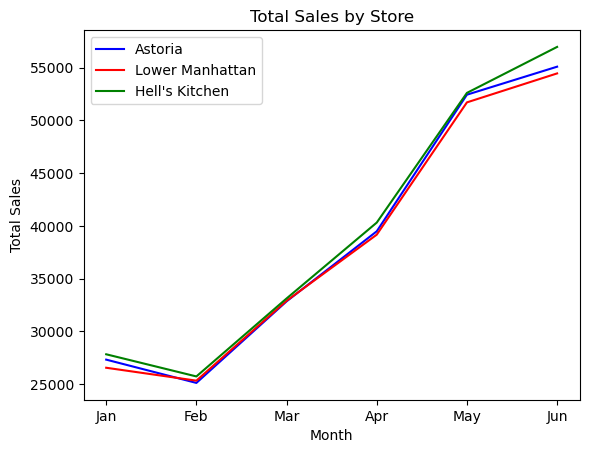

<Figure size 6000x1000 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [136]:
#Dispalay the total sales for each store as a line graph
plt.plot(store1_totalsales, label='Astoria', color='blue')
plt.plot(store2_totalsales, label='Lower Manhattan', color='red')
plt.plot(store3_totalsales, label="Hell's Kitchen", color='green')

#Change the x-axis to display the month name
plt.xticks(store1_totalsales.index, ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun'])


plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.title('Total Sales by Store')
plt.legend(loc='best')
plt.figure(figsize=(60,10))

plt.show()

#Save the figure
plt.savefig('Images/TotalSalesbyStore.png')


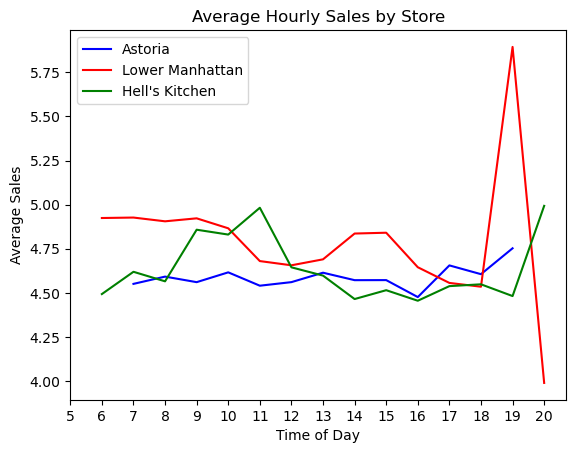

<Figure size 6000x1000 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [137]:
#Create a dataframe for each store's average sales using the custom function by hour
store1_avgsales = store1_df.groupby('hour').apply(avg_totalsales)
store2_avgsales = store2_df.groupby('hour').apply(avg_totalsales)
store3_avgsales = store3_df.groupby('hour').apply(avg_totalsales)

#Dispalay the average sales for each store as a line graph
plt.plot(store1_avgsales, label='Astoria', color='blue')
plt.plot(store2_avgsales, label='Lower Manhattan', color='red')
plt.plot(store3_avgsales, label="Hell's Kitchen", color='green')

#Change the x axis to display hours as 12 hour time label starting at 6am and ending at 8pm
plt.xticks(np.arange(5, 21, 1))


plt.xlabel('Time of Day')
plt.ylabel('Average Sales')
plt.title('Average Hourly Sales by Store')
plt.legend(loc='best')
plt.figure(figsize=(60,10))

plt.show()

#Save the figure
plt.savefig('Images/AverageSalesbyStore.png')



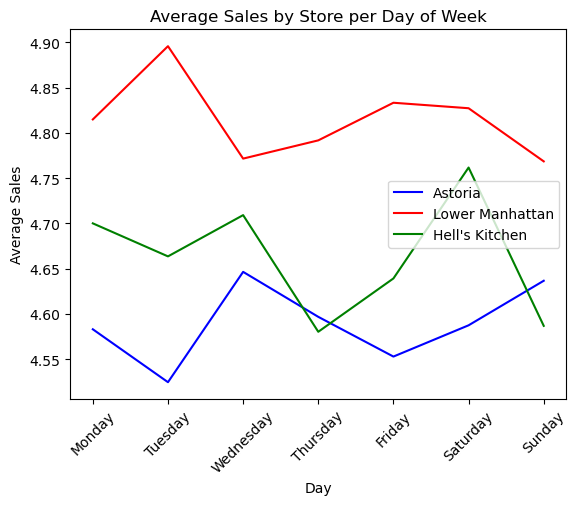

<Figure size 6000x1000 with 0 Axes>

In [138]:
#Create a dataframe for each store's average sales using the custom function by day of week
store1_avgsales = store1_df.groupby('dayofweek').apply(avg_totalsales)
store2_avgsales = store2_df.groupby('dayofweek').apply(avg_totalsales)
store3_avgsales = store3_df.groupby('dayofweek').apply(avg_totalsales)

#Dispalay the average sales for each store as a line graph
plt.plot(store1_avgsales, label='Astoria', color='blue')
plt.plot(store2_avgsales, label='Lower Manhattan', color='red')
plt.plot(store3_avgsales, label="Hell's Kitchen", color='green')

#Change the x axis labels to day of week names
plt.xticks(np.arange(7), ('Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'), rotation=45)

plt.xlabel('Day')
plt.ylabel('Average Sales')
plt.title('Average Sales by Store per Day of Week')
plt.legend(loc='best')
plt.figure(figsize=(60,10))

#Save the figure
plt.savefig('Images/AverageSalesbyStoreperDayofWeek.png')


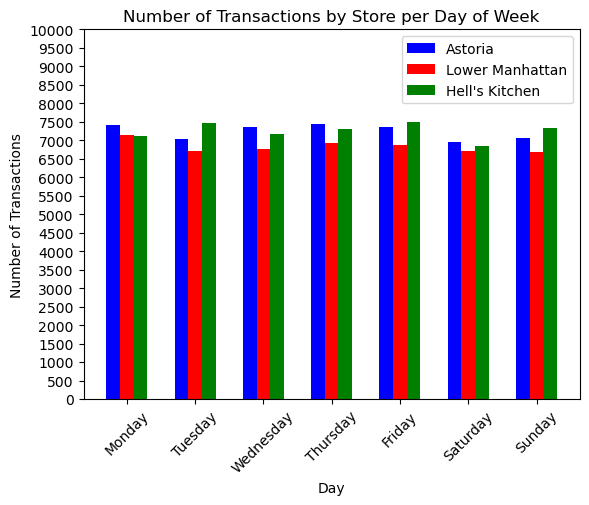

<Figure size 6000x1000 with 0 Axes>

In [139]:
#create a dataframe for each store's total number of transactions by day of week
store1_transactions = store1_df.groupby('dayofweek').count()
store2_transactions = store2_df.groupby('dayofweek').count()
store3_transactions = store3_df.groupby('dayofweek').count()

#display(store1_transactions)
#display(store2_transactions)
#display(store3_transactions)

#Display the total number of transactions for each store as a bar graph with each store's data side by side as narrow bars
plt.bar(store1_transactions.index - 0.2, store1_transactions['transaction_id'], width=0.2, label='Astoria', color='blue')
plt.bar(store2_transactions.index, store2_transactions['transaction_id'], width=0.2, label='Lower Manhattan', color='red')
plt.bar(store3_transactions.index + 0.2, store3_transactions['transaction_id'], width=0.2, label="Hell's Kitchen", color='green')


#Change the x axis labels to day of week names
plt.xticks(np.arange(7), ('Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'), rotation=45)

#Increase the maximum y axis value to 10000
plt.ylim(0, 10000)
plt.yticks(np.arange(0, 10001, 500))


plt.xlabel('Day')
plt.ylabel('Number of Transactions')
plt.title('Number of Transactions by Store per Day of Week')
plt.legend(loc='best')
plt.figure(figsize=(60,10))

#Save the figure
plt.savefig('Images/NumberofTransactionsbyStoreperDayofWeek.png')


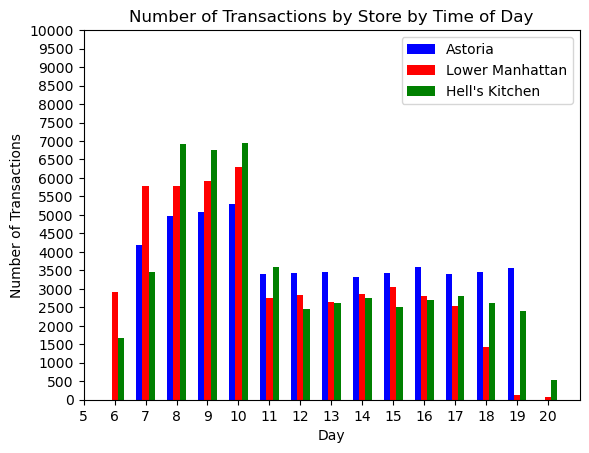

<Figure size 6000x1000 with 0 Axes>

In [140]:
#create a dataframe for each store's total number of transactions by hour
store1_transactions = store1_df.groupby('hour').count()
store2_transactions = store2_df.groupby('hour').count()
store3_transactions = store3_df.groupby('hour').count()

#display(store1_transactions)
#display(store2_transactions)
#display(store3_transactions)

#Display the total number of transactions for each store as a bar graph with each store's data side by side as narrow bars
plt.bar(store1_transactions.index - 0.2, store1_transactions['transaction_id'], width=0.2, label='Astoria', color='blue')
plt.bar(store2_transactions.index, store2_transactions['transaction_id'], width=0.2, label='Lower Manhattan', color='red')
plt.bar(store3_transactions.index + 0.2, store3_transactions['transaction_id'], width=0.2, label="Hell's Kitchen", color='green')

#Change the x axis to display hours as 12 hour time label starting at 6am and ending at 8pm
plt.xticks(np.arange(5, 21, 1))

#Increase the maximum y axis value to 10000
plt.ylim(0, 10000)
plt.yticks(np.arange(0, 10001, 500))

plt.xlabel('Day')
plt.ylabel('Number of Transactions')
plt.title('Number of Transactions by Store by Time of Day')
plt.legend(loc='best')
plt.figure(figsize=(60,10))

#Save the figure
plt.savefig('Images/NumberofTransactionsbyStorebyTimeofDay.png')

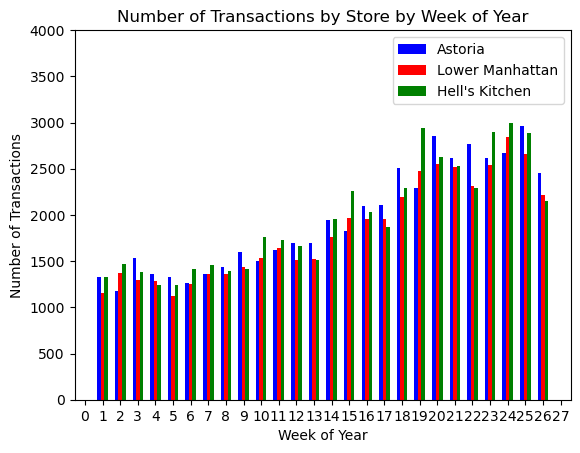

<Figure size 6000x1000 with 0 Axes>

In [141]:
#Create a dataframe for each store's total number of transactions by week of year
store1_transactions = store1_df.groupby('weekofyear').count()
store2_transactions = store2_df.groupby('weekofyear').count()
store3_transactions = store3_df.groupby('weekofyear').count()

#display(store1_transactions)
#display(store2_transactions)
#display(store3_transactions)

#Convert the week of year column to an integer
store1_transactions.index = store1_transactions.index.astype(int)
store2_transactions.index = store2_transactions.index.astype(int)
store3_transactions.index = store3_transactions.index.astype(int)

#Display the total number of transactions for each store as a bar graph with each store's data side by side as narrow bars
plt.bar(store1_transactions.index - 0.2, store1_transactions['transaction_id'], width=0.2, label='Astoria', color='blue')
plt.bar(store2_transactions.index, store2_transactions['transaction_id'], width=0.2, label='Lower Manhattan', color='red')
plt.bar(store3_transactions.index + 0.2, store3_transactions['transaction_id'], width=0.2, label="Hell's Kitchen", color='green')

#Change the x axis to display week of year
plt.xticks(np.arange(0, 28, 1))

#Increase the maximum y axis value to 4000
plt.ylim(0, 4000)
plt.yticks(np.arange(0, 4001, 500))

plt.xlabel('Week of Year')
plt.ylabel('Number of Transactions')
plt.title('Number of Transactions by Store by Week of Year')
plt.legend(loc='best')
plt.figure(figsize=(60,10))

#Save the figure
plt.savefig('Images/NumberofTransactionsbyStorebyWeekofYear.png')



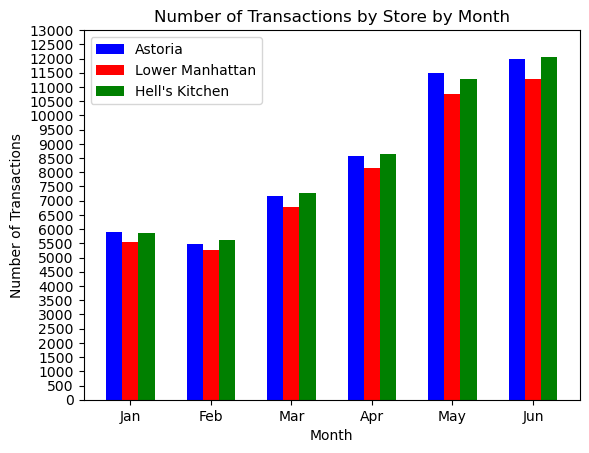

<Figure size 6000x1000 with 0 Axes>

In [142]:
#Create a dataframe for each store's total number of transactions by month
store1_transactions = store1_df.groupby('month').count()
store2_transactions = store2_df.groupby('month').count()
store3_transactions = store3_df.groupby('month').count()

#display(store1_transactions)
#display(store2_transactions)
#display(store3_transactions)

#Display the total number of transactions for each store as a bar graph with each store's data side by side as narrow bars
plt.bar(store1_transactions.index - 0.2, store1_transactions['transaction_id'], width=0.2, label='Astoria', color='blue')
plt.bar(store2_transactions.index, store2_transactions['transaction_id'], width=0.2, label='Lower Manhattan', color='red')
plt.bar(store3_transactions.index + 0.2, store3_transactions['transaction_id'], width=0.2, label="Hell's Kitchen", color='green')

#Change the x axis to display month names
plt.xticks(store1_transactions.index, ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun'])

#Increase the maximum y axis value to 13000
plt.ylim(0, 13000)
plt.yticks(np.arange(0, 13001, 500))

plt.xlabel('Month')
plt.ylabel('Number of Transactions')
plt.title('Number of Transactions by Store by Month')
plt.legend(loc='best')
plt.figure(figsize=(60,10))

#Save the figure
plt.savefig('Images/NumberofTransactionsbyStorebyMonth.png')


In [143]:
#Make a forecast for each store using Prophet of number of transaction by month for each store
#Create a dataframe for each store's total number of transactions by month with month as a column and number of transactions as a column
store1_transactions = store1_df.groupby('month').count()
store2_transactions = store2_df.groupby('month').count()
store3_transactions = store3_df.groupby('month').count()

display(store1_transactions.head(2))
display(store2_transactions.head(2))
display(store3_transactions.head(2))

#Drop all columns except for month and transaction id
store1_transactions = store1_transactions.drop(columns=['transaction_date', 'transaction_time', 'store_id','store_location', 'transaction_qty', 'unit_price', 'totalsales', 'dayofweek', 'hour', 'product_id','product_category','product_type','product_detail', 'weekofyear'])
store2_transactions = store2_transactions.drop(columns=['transaction_date', 'transaction_time', 'store_id','store_location', 'transaction_qty', 'unit_price', 'totalsales', 'dayofweek', 'hour', 'product_id','product_category','product_type','product_detail', 'weekofyear'])
store3_transactions = store3_transactions.drop(columns=['transaction_date', 'transaction_time', 'store_id','store_location', 'transaction_qty', 'unit_price', 'totalsales', 'dayofweek', 'hour', 'product_id','product_category','product_type','product_detail', 'weekofyear'])

#display(store1_transactions)
#display(store2_transactions)
#display(store3_transactions)

#Rename the transaction id column to y and the week of year column to ds
store1_transactions = store1_transactions.rename(columns={'transaction_id': 'y'})
store2_transactions = store2_transactions.rename(columns={'transaction_id': 'y'})
store3_transactions = store3_transactions.rename(columns={'transaction_id': 'y'})

#Flatten the dataframe
store1_transactions = store1_transactions.reset_index()
store2_transactions = store2_transactions.reset_index()
store3_transactions = store3_transactions.reset_index()

store1_transactions = store1_transactions.rename(columns={'month': 'ds'})
store2_transactions = store2_transactions.rename(columns={'month': 'ds'})
store3_transactions = store3_transactions.rename(columns={'month': 'ds'})

#Convert the ds column to datetime equal to the first day of the month of the month number  listed in the ds column and the year equal to 2023
store1_transactions['ds'] = pd.to_datetime(store1_transactions['ds'].astype(str) + '/1/2023')
store2_transactions['ds'] = pd.to_datetime(store2_transactions['ds'].astype(str) + '/1/2023')
store3_transactions['ds'] = pd.to_datetime(store3_transactions['ds'].astype(str) + '/1/2023')


#display(store1_transactions)
#display(store2_transactions)
#display(store3_transactions)

#Remove any rows with null values
store1_transactions = store1_transactions.dropna()
store2_transactions = store2_transactions.dropna()
store3_transactions = store3_transactions.dropna()


#display(store1_transactions)
#display(store2_transactions)
#display(store3_transactions)

#Create a Prophet model for each store
store1_model = Prophet()
store2_model = Prophet()
store3_model = Prophet()

#display(store1_model)
#display(store2_model)
#display(store3_model)

#Fit each model to the data
store1_model.fit(store1_transactions)
store2_model.fit(store2_transactions)
store3_model.fit(store3_transactions)

#Create a dataframe for each store's forecast
store1_forecast = store1_model.make_future_dataframe(periods=6, freq='M')
store2_forecast = store2_model.make_future_dataframe(periods=6, freq='M')
store3_forecast = store3_model.make_future_dataframe(periods=6, freq='M')

# Make a forecast based on the future DataFrame
store1_forecast = store1_model.predict(store1_forecast)
store2_forecast = store2_model.predict(store2_forecast)
store3_forecast = store3_model.predict(store3_forecast)

#display(store1_forecast)
#display(store2_forecast)
#display(store3_forecast)




,transaction_id,transaction_date,transaction_time,transaction_qty,store_id,store_location,product_id,unit_price,product_category,product_type,product_detail,totalsales,weekofyear,dayofweek,hour
month,,,,,,,,,,,,,,,
1,5913,5913,5913,5913,5913,5913,5913,5913,5913,5913,5913,5913,5913,5913,5913
2,5490,5490,5490,5490,5490,5490,5490,5490,5490,5490,5490,5490,5490,5490,5490


,transaction_id,transaction_date,transaction_time,transaction_qty,store_id,store_location,product_id,unit_price,product_category,product_type,product_detail,totalsales,weekofyear,dayofweek,hour
month,,,,,,,,,,,,,,,
1,5533,5533,5533,5533,5533,5533,5533,5533,5533,5533,5533,5533,5533,5533,5533
2,5263,5263,5263,5263,5263,5263,5263,5263,5263,5263,5263,5263,5263,5263,5263


,transaction_id,transaction_date,transaction_time,transaction_qty,store_id,store_location,product_id,unit_price,product_category,product_type,product_detail,totalsales,weekofyear,dayofweek,hour
month,,,,,,,,,,,,,,,
1,5868,5868,5868,5868,5868,5868,5868,5868,5868,5868,5868,5868,5868,5868,5868
2,5606,5606,5606,5606,5606,5606,5606,5606,5606,5606,5606,5606,5606,5606,5606


21:38:39 - cmdstanpy - INFO - Chain [1] start processing
21:38:39 - cmdstanpy - INFO - Chain [1] done processing
21:38:39 - cmdstanpy - INFO - Chain [1] start processing
21:38:39 - cmdstanpy - INFO - Chain [1] done processing
21:38:39 - cmdstanpy - INFO - Chain [1] start processing
21:38:39 - cmdstanpy - INFO - Chain [1] done processing


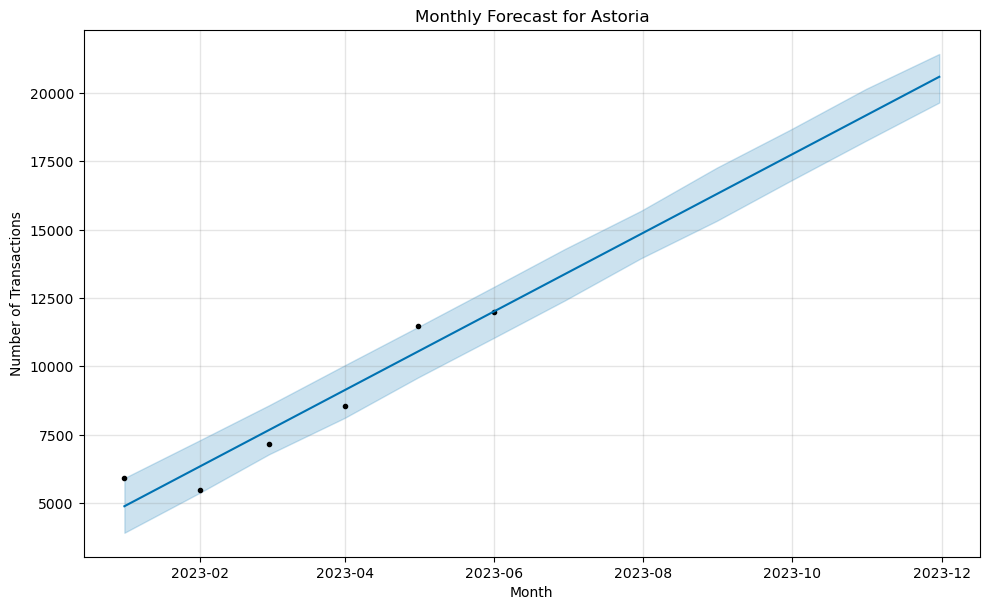

<Figure size 640x480 with 0 Axes>

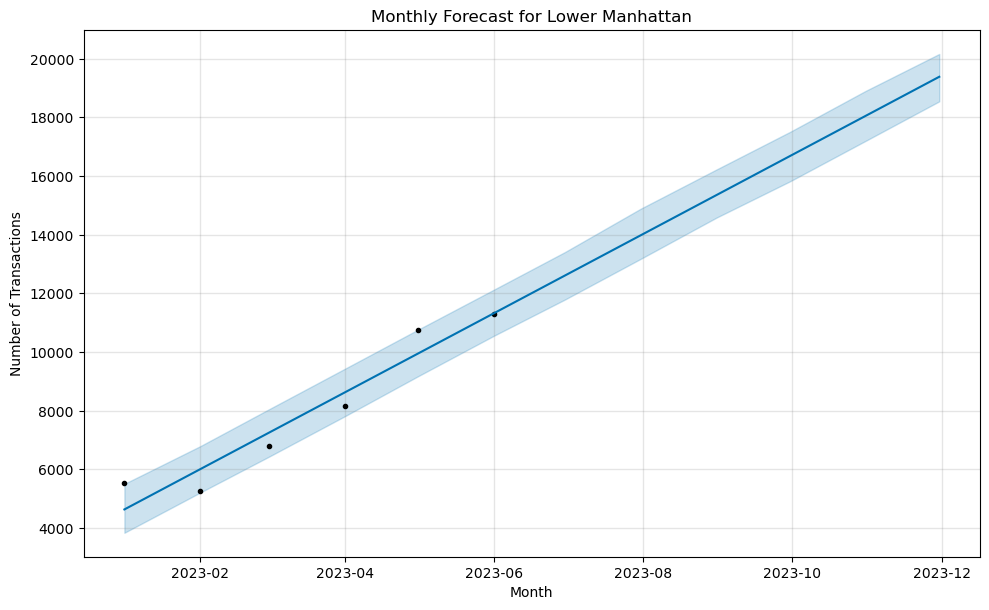

<Figure size 640x480 with 0 Axes>

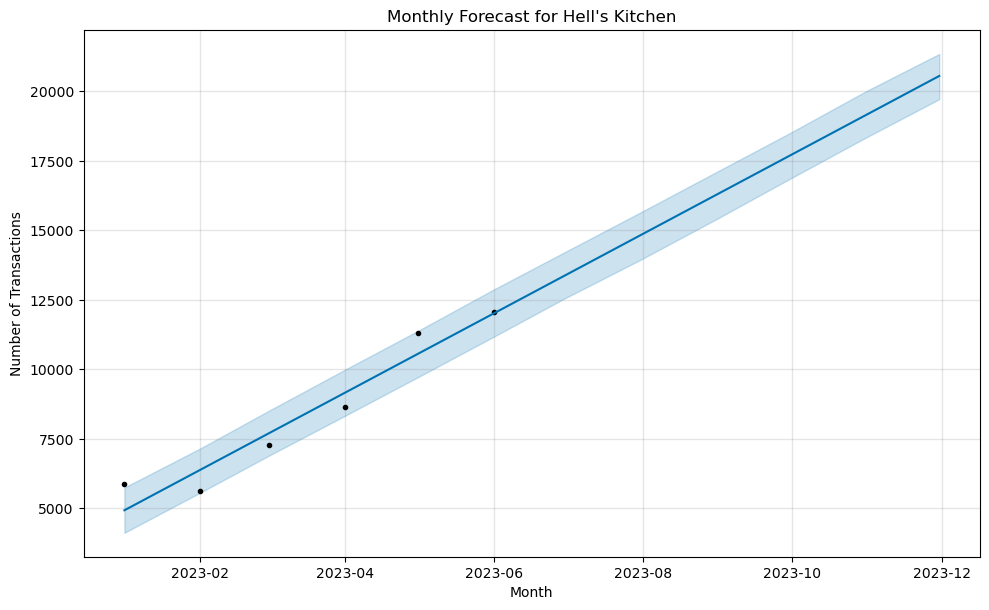

<Figure size 640x480 with 0 Axes>

In [144]:
#Plot the forecast for each store using above data
#Show the forecast for each store as a line graph with the actual data as dots
#Show the forecast as a shaded area
#Show the x axis as month and the y axis as number of transactions
#Show the title as Forecast for Store Name

store1_model.plot(store1_forecast, xlabel='Month', ylabel='Number of Transactions')
plt.title('Monthly Forecast for Astoria')
plt.show()

#Save the figure
plt.savefig('Images/MonthlyForecastforAstoria.png')

store2_model.plot(store2_forecast, xlabel='Month', ylabel='Number of Transactions')
plt.title('Monthly Forecast for Lower Manhattan')
plt.show()

#Save the figure
plt.savefig('Images/MonthlyForecastforLowerManhattan.png')

store3_model.plot(store3_forecast, xlabel='Month', ylabel='Number of Transactions')
plt.title('Monthly Forecast for Hell\'s Kitchen')
plt.show()

#Save the figure
plt.savefig('Images/MonthlyForecastforHellsKitchen.png')



In [145]:
#Make a forecast for each store using Prophet of number of transaction by week of year for each store
#Create a dataframe for each store's total number of transactions by month with week of year as a column and number of transactions as a column
store1_transactions = store1_df.groupby('weekofyear').count()
store2_transactions = store2_df.groupby('weekofyear').count()
store3_transactions = store3_df.groupby('weekofyear').count()

#display(store1_transactions.head(2))
#display(store2_transactions.head(2))
#display(store3_transactions.head(2))

#Drop all columns except for month and transaction id
store1_transactions = store1_transactions.drop(columns=['transaction_date', 'transaction_time', 'store_id','store_location', 'transaction_qty', 'unit_price', 'totalsales', 'dayofweek', 'hour', 'product_id','product_category','product_type','product_detail', 'month'])
store2_transactions = store2_transactions.drop(columns=['transaction_date', 'transaction_time', 'store_id','store_location', 'transaction_qty', 'unit_price', 'totalsales', 'dayofweek', 'hour', 'product_id','product_category','product_type','product_detail', 'month'])
store3_transactions = store3_transactions.drop(columns=['transaction_date', 'transaction_time', 'store_id','store_location', 'transaction_qty', 'unit_price', 'totalsales', 'dayofweek', 'hour', 'product_id','product_category','product_type','product_detail', 'month'])

#display(store1_transactions)
#display(store2_transactions)
#display(store3_transactions)

#Rename the transaction id column to y and the week of year column to ds
store1_transactions = store1_transactions.rename(columns={'transaction_id': 'y'})
store2_transactions = store2_transactions.rename(columns={'transaction_id': 'y'})
store3_transactions = store3_transactions.rename(columns={'transaction_id': 'y'})

#Flatten the dataframe
store1_transactions = store1_transactions.reset_index()
store2_transactions = store2_transactions.reset_index()
store3_transactions = store3_transactions.reset_index()

store1_transactions = store1_transactions.rename(columns={'weekofyear': 'ds'})
store2_transactions = store2_transactions.rename(columns={'weekofyear': 'ds'})
store3_transactions = store3_transactions.rename(columns={'weekofyear': 'ds'})

"2023-W" + store1_transactions['ds']

#Create a custom function to convert the week of year to a date
def weekofyear_to_date(df):
    return datetime.datetime.strptime("2023-W" + df['ds'] + '-1', "%Y-W%W-%w")

#Convert the ds column to datetime using the custom function
store1_transactions['ds'] = store1_transactions.apply(weekofyear_to_date, axis=1)
store2_transactions['ds'] = store2_transactions.apply(weekofyear_to_date, axis=1)
store3_transactions['ds'] = store3_transactions.apply(weekofyear_to_date, axis=1)



#display(store1_transactions)
#display(store2_transactions)
#display(store3_transactions)

#Remove any rows with null values
store1_transactions = store1_transactions.dropna()
store2_transactions = store2_transactions.dropna()
store3_transactions = store3_transactions.dropna()


#display(store1_transactions)
#display(store2_transactions)
#display(store3_transactions)

#Create a Prophet model for each store
store1_model = Prophet()
store2_model = Prophet()
store3_model = Prophet()

#display(store1_model)
#display(store2_model)
#display(store3_model)

#Fit each model to the data
store1_model.fit(store1_transactions)
store2_model.fit(store2_transactions)
store3_model.fit(store3_transactions)

#Create a dataframe for each store's forecast
store1_forecast = store1_model.make_future_dataframe(periods=26, freq='W')
store2_forecast = store2_model.make_future_dataframe(periods=26, freq='W')
store3_forecast = store3_model.make_future_dataframe(periods=26, freq='W')

# Make a forecast based on the future DataFrame
store1_forecast = store1_model.predict(store1_forecast)
store2_forecast = store2_model.predict(store2_forecast)
store3_forecast = store3_model.predict(store3_forecast)

#display(store1_forecast)
#display(store2_forecast)
#display(store3_forecast)

21:38:39 - cmdstanpy - INFO - Chain [1] start processing
21:38:39 - cmdstanpy - INFO - Chain [1] done processing
21:38:40 - cmdstanpy - INFO - Chain [1] start processing
21:38:40 - cmdstanpy - INFO - Chain [1] done processing
21:38:40 - cmdstanpy - INFO - Chain [1] start processing
21:38:40 - cmdstanpy - INFO - Chain [1] done processing


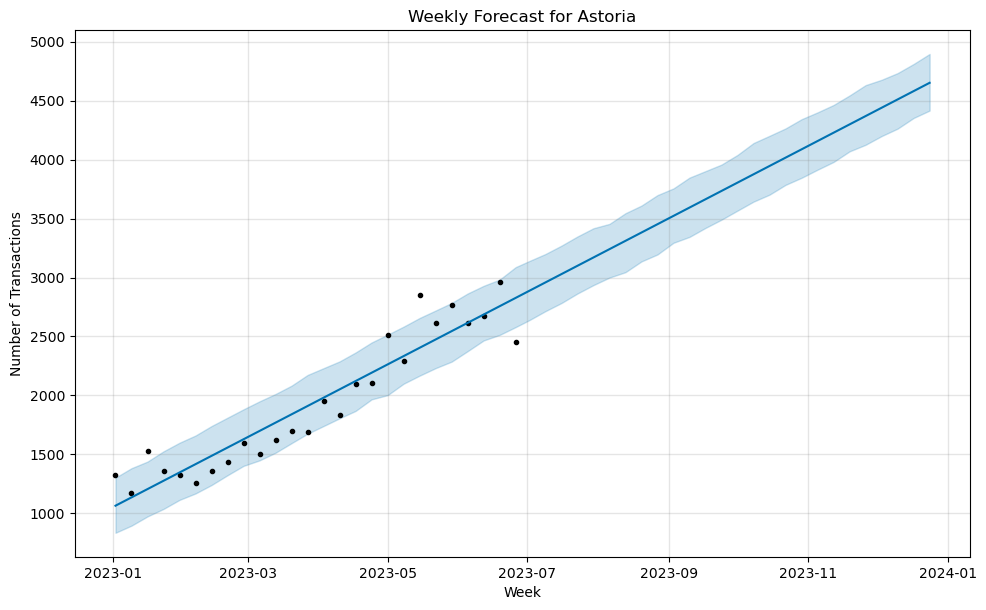

<Figure size 640x480 with 0 Axes>

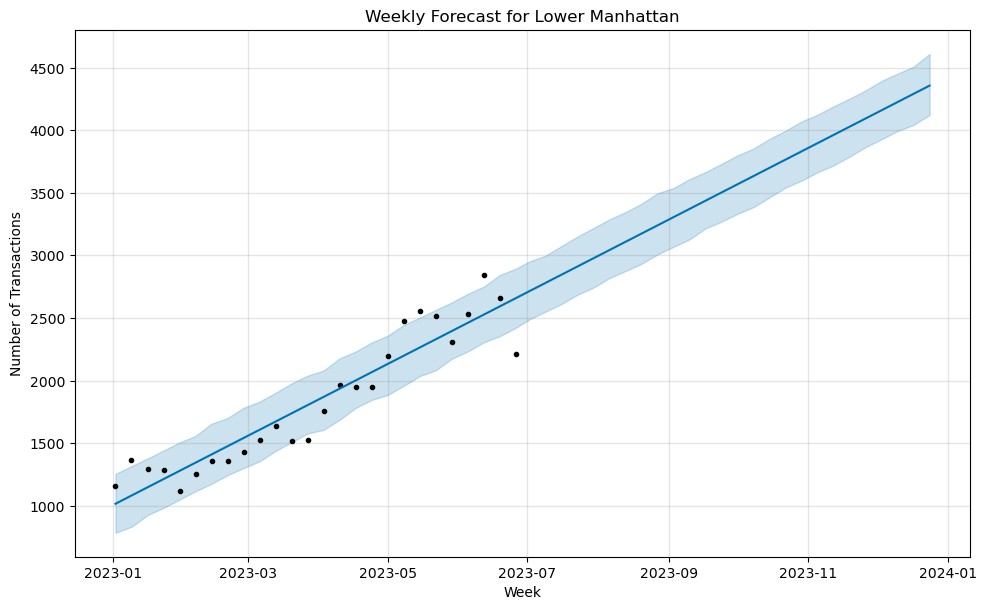

<Figure size 640x480 with 0 Axes>

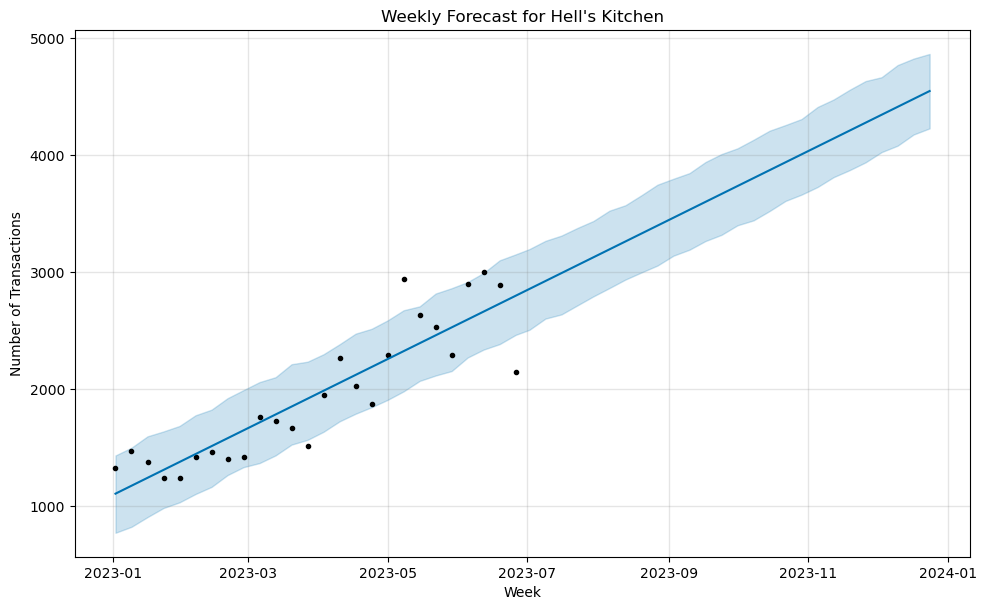

<Figure size 640x480 with 0 Axes>

In [146]:
#Plot the forecast for each store using above data
#Show the forecast for each store as a line graph with the actual data as dots
#Show the forecast as a shaded area
#Show the x axis as week and the y axis as number of transactions
#Show the title as Forecast for Store Name

store1_model.plot(store1_forecast, xlabel='Week', ylabel='Number of Transactions')
plt.title('Weekly Forecast for Astoria')
plt.show()

#Save the figure
plt.savefig('Images/WeeklyForecastforAstoria.png')

store2_model.plot(store2_forecast, xlabel='Week', ylabel='Number of Transactions')
plt.title('Weekly Forecast for Lower Manhattan')
plt.show()

#Save the figure
plt.savefig('Images/WeeklyForecastforLowerManhattan.png')

store3_model.plot(store3_forecast, xlabel='Week', ylabel='Number of Transactions')
plt.title('Weekly Forecast for Hell\'s Kitchen')
plt.show()

#Save the figure
plt.savefig('Images/WeeklyForecastforHellsKitchen.png')

